In [1]:
import tensorflow as tf
import tensorflow .contrib.slim as slim
import numpy as np
import random
from game_env import gameEnv
import os
import matplotlib.pyplot as plt
import scipy.misc

c:\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gameEnv(84,3)
env.drawGridState()
env.actions

15

In [4]:
class Qnetwork():
    def __init__(self,h_size):
        #Receives a (P,P,3) representation of the game, pixels x pixels by rgb,
        #specified when creating game environment
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])

        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [7]:
def processState(states):
    return np.reshape(states,[21168])

In [8]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 50000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = True #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [ ]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Resetting env and getting first observation
        env.reset()
        s = env.reset()
        s = processState(s)

        d = env.game_over
        rAll = 0
        j = 0
        #The Q-Network
        #If agent takes longer than max episodes, end trial
        while j < max_epLength:
            j += 1
            #Choose action greedily(with e chance of random action) from Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,15)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            #Save the experience to our episode buffer.
            

            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
            
            
            
            
            
            
            

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn\model-0.ckpt
Saved Model
97 -2.74 1
189 -2.64 1
256 -2.1399999999999997 1
341 -2.5 1
432 -2.62 1
522 -2.6 1
611 -2.58 1
699 -2.5600000000000005 1
788 -2.5799999999999996 1
876 -2.56 1
1000 -3.2800000000000002 1
1126 -3.3200000000000003 1
1248 -3.2400000000000007 1
1310 -2.04 1
1389 -2.38 1
1493 -2.88 1
1592 -2.7800000000000002 1
1652 -1.9999999999999996 1
1772 -3.2 1
1877 -2.900000000000001 1
1997 -3.2 1
2071 -2.28 1
2169 -2.7600000000000002 1
2257 -2.5600000000000005 1
2393 -3.439999999999999 1
2491 -2.76 1
2596 -2.9 1
2652 -1.92 1
2719 -2.1399999999999997 1
2803 -2.48 1
2918 -3.1 1
2964 -1.72 1
3063 -2.7800000000000002 1
3137 -2.2800000000000002 1
3226 -2.5799999999999996 1
3275 -1.78 1
3355 -2.4000000000000004 1
3447 -2.64 1
3541 -2.6800000000000006 1
3663 -3.2400000000000007 1
3780 -3.140000000000001 1
3893 -3.06 1
3984 -2.62 1
4077 -2.66 1
4202 

28165 -0.33999999999999997 0.09999999999985551
28232 -0.33999999999999997 0.09999999999985551
28301 -0.17999999999999997 0.09999999999985551
28367 -0.11999999999999997 0.09999999999985551
28434 -0.13999999999999996 0.09999999999985551
28544 -1.3199999999999996 0.09999999999985551
28604 -0.39999999999999997 0.09999999999985551
28802 -3.319999999999999 0.09999999999985551
28867 -0.3 0.09999999999985551
28939 -0.23999999999999994 0.09999999999985551
29053 -1.48 0.09999999999985551
29118 -0.3 0.09999999999985551
29179 -0.62 0.09999999999985551
29248 -0.17999999999999997 0.09999999999985551
29360 -1.7599999999999998 0.09999999999985551
29427 -0.13999999999999996 0.09999999999985551
29495 -0.36 0.09999999999985551
29581 -0.9200000000000002 0.09999999999985551
29714 -1.9799999999999998 0.09999999999985551
29779 -0.3 0.09999999999985551
29856 -0.5399999999999999 0.09999999999985551
29924 -0.15999999999999998 0.09999999999985551
30031 -1.0599999999999996 0.09999999999985551
30101 -0.19999999999

42884 -0.4999999999999999 0.09999999999985551
42954 -0.39999999999999997 0.09999999999985551
43021 -0.13999999999999996 0.09999999999985551
43081 -0.19999999999999998 0.09999999999985551
43151 -0.19999999999999996 0.09999999999985551
43226 -0.4999999999999999 0.09999999999985551
43295 -0.38 0.09999999999985551
43363 -0.15999999999999998 0.09999999999985551
43434 -0.21999999999999992 0.09999999999985551
43497 -0.26 0.09999999999985551
43569 -0.44000000000000006 0.09999999999985551
43634 -0.09999999999999998 0.09999999999985551
43709 -0.4999999999999999 0.09999999999985551
43780 -0.21999999999999992 0.09999999999985551
43844 -0.07999999999999999 0.09999999999985551
43917 -0.25999999999999995 0.09999999999985551
43981 -0.27999999999999997 0.09999999999985551
44043 -0.43999999999999995 0.09999999999985551
44126 -0.45999999999999996 0.09999999999985551
44190 -0.4800000000000001 0.09999999999985551
44261 -0.21999999999999992 0.09999999999985551
44331 -0.39999999999999997 0.09999999999985551


55640 -0.12 0.09999999999985551
55714 -0.2799999999999999 0.09999999999985551
55783 -0.17999999999999997 0.09999999999985551
55844 -0.21999999999999997 0.09999999999985551
55919 -0.29999999999999993 0.09999999999985551
55983 -0.07999999999999999 0.09999999999985551
56053 -0.19999999999999996 0.09999999999985551
56127 -0.48 0.09999999999985551
56198 -0.21999999999999992 0.09999999999985551
56260 -0.24 0.09999999999985551
56332 -0.23999999999999994 0.09999999999985551
56400 -0.15999999999999998 0.09999999999985551
56474 -0.48 0.09999999999985551
56542 -0.5599999999999999 0.09999999999985551
56616 -0.2799999999999999 0.09999999999985551
56687 -0.21999999999999992 0.09999999999985551
56757 -0.19999999999999996 0.09999999999985551
56834 -0.33999999999999997 0.09999999999985551
56909 -0.29999999999999993 0.09999999999985551
56980 -0.42000000000000004 0.09999999999985551
57054 -0.47999999999999987 0.09999999999985551
57123 -0.17999999999999997 0.09999999999985551
57188 -0.09999999999999998 0.

68279 -0.2799999999999999 0.09999999999985551
68348 -0.17999999999999997 0.09999999999985551
68419 -0.6199999999999999 0.09999999999985551
68493 -0.2799999999999999 0.09999999999985551
68564 -0.21999999999999992 0.09999999999985551
68637 -0.25999999999999995 0.09999999999985551
68703 -0.31999999999999995 0.09999999999985551
68764 -0.22000000000000003 0.09999999999985551
68825 -0.21999999999999992 0.09999999999985551
68887 -0.039999999999999994 0.09999999999985551
68943 -0.52 0.09999999999985551
69003 -0.19999999999999998 0.09999999999985551
69073 -0.19999999999999996 0.09999999999985551
69136 -0.25999999999999995 0.09999999999985551
69200 -0.27999999999999997 0.09999999999985551
69265 -0.3 0.09999999999985551
69331 -0.11999999999999997 0.09999999999985551
69401 -0.19999999999999996 0.09999999999985551
69471 -0.19999999999999996 0.09999999999985551
69540 -0.17999999999999997 0.09999999999985551
69611 -0.21999999999999992 0.09999999999985551
69672 -0.41999999999999993 0.09999999999985551

81083 -0.13999999999999996 0.09999999999985551
81150 -0.13999999999999996 0.09999999999985551
81217 -0.13999999999999996 0.09999999999985551
81285 -0.15999999999999998 0.09999999999985551
81346 -0.21999999999999997 0.09999999999985551
81411 -0.09999999999999998 0.09999999999985551
81477 -0.31999999999999995 0.09999999999985551
81545 -0.36 0.09999999999985551
81609 -0.27999999999999997 0.09999999999985551
81678 -0.17999999999999997 0.09999999999985551
81755 -0.3399999999999999 0.09999999999985551
Saved Model
81822 -0.13999999999999996 0.09999999999985551
81895 -0.45999999999999996 0.09999999999985551
81965 -0.5999999999999999 0.09999999999985551
82034 -0.38 0.09999999999985551
82101 -0.33999999999999997 0.09999999999985551
82174 -0.25999999999999995 0.09999999999985551
82236 -0.24000000000000005 0.09999999999985551
82299 -0.059999999999999984 0.09999999999985551
82368 -0.17999999999999997 0.09999999999985551
82434 -0.31999999999999995 0.09999999999985551
82498 -0.07999999999999999 0.099

93742 -0.07999999999999999 0.09999999999985551
93826 -0.47999999999999987 0.09999999999985551
93892 -0.11999999999999997 0.09999999999985551
93959 -0.13999999999999996 0.09999999999985551
94030 -0.21999999999999992 0.09999999999985551
94099 -0.17999999999999997 0.09999999999985551
94163 -0.27999999999999997 0.09999999999985551
94232 -0.38 0.09999999999985551
94299 -0.33999999999999997 0.09999999999985551
94371 -0.23999999999999994 0.09999999999985551
94444 -0.2599999999999999 0.09999999999985551
94523 -0.37999999999999995 0.09999999999985551
94594 -0.42000000000000004 0.09999999999985551
94664 -0.19999999999999996 0.09999999999985551
94726 -0.44000000000000006 0.09999999999985551
94788 -0.23999999999999994 0.09999999999985551
94861 -0.45999999999999996 0.09999999999985551
94931 -0.19999999999999996 0.09999999999985551
94999 -0.36 0.09999999999985551
95063 -0.47999999999999987 0.09999999999985551
95130 -0.13999999999999996 0.09999999999985551
95201 -0.21999999999999992 0.099999999999855

106563 -0.15999999999999998 0.09999999999985551
106635 -0.23999999999999994 0.09999999999985551
106698 -0.4600000000000001 0.09999999999985551
106760 -0.64 0.09999999999985551
106821 -0.21999999999999997 0.09999999999985551
106884 -0.25999999999999995 0.09999999999985551
106950 -0.32 0.09999999999985551
107010 0.0 0.09999999999985551
107080 -0.19999999999999993 0.09999999999985551
107156 -0.31999999999999995 0.09999999999985551
107227 -0.21999999999999992 0.09999999999985551
107296 -0.17999999999999997 0.09999999999985551
107361 -0.29999999999999993 0.09999999999985551
107438 -0.33999999999999997 0.09999999999985551
107505 -0.13999999999999996 0.09999999999985551
107570 -0.29999999999999993 0.09999999999985551
107626 -0.72 0.09999999999985551
107694 -0.15999999999999998 0.09999999999985551
107760 -0.11999999999999997 0.09999999999985551
107833 -0.45999999999999996 0.09999999999985551
107907 -0.2799999999999999 0.09999999999985551
107977 -0.39999999999999997 0.09999999999985551
108045 -

118929 -0.31999999999999995 0.09999999999985551
118997 -0.15999999999999998 0.09999999999985551
119067 -0.19999999999999993 0.09999999999985551
119145 -0.35999999999999993 0.09999999999985551
119226 -0.41999999999999993 0.09999999999985551
119296 -0.19999999999999996 0.09999999999985551
119361 -0.29999999999999993 0.09999999999985551
119426 -0.09999999999999998 0.09999999999985551
119495 -0.17999999999999997 0.09999999999985551
119559 -0.27999999999999997 0.09999999999985551
119625 -0.11999999999999997 0.09999999999985551
119695 -0.4 0.09999999999985551
119770 -0.4999999999999999 0.09999999999985551
119840 -0.3999999999999999 0.09999999999985551
119908 -0.15999999999999998 0.09999999999985551
119981 -0.25999999999999995 0.09999999999985551
120044 -0.25999999999999995 0.09999999999985551
120103 -0.18 0.09999999999985551
120174 -0.21999999999999992 0.09999999999985551
120250 -0.5199999999999999 0.09999999999985551
120317 -0.13999999999999996 0.09999999999985551
120392 -0.2999999999999999

131032 -0.17999999999999997 0.09999999999985551
131095 -0.25999999999999995 0.09999999999985551
131162 -0.13999999999999996 0.09999999999985551
131236 -0.47999999999999987 0.09999999999985551
131306 -0.4 0.09999999999985551
131379 -0.25999999999999995 0.09999999999985551
131458 -0.37999999999999995 0.09999999999985551
131528 -0.19999999999999996 0.09999999999985551
131589 -0.22000000000000003 0.09999999999985551
131651 -0.23999999999999994 0.09999999999985551
131705 -0.2799999999999999 0.09999999999985551
131779 -0.2799999999999999 0.09999999999985551
131849 -0.4 0.09999999999985551
131915 -0.5199999999999999 0.09999999999985551
131985 -0.19999999999999996 0.09999999999985551
132061 -0.31999999999999995 0.09999999999985551
132126 -0.3 0.09999999999985551
132198 -0.44000000000000006 0.09999999999985551
132274 -0.31999999999999995 0.09999999999985551
132344 -0.4 0.09999999999985551
132415 -0.21999999999999992 0.09999999999985551
132479 -0.27999999999999997 0.09999999999985551
132553 -0.4

143649 -0.23999999999999994 0.09999999999985551
143716 -0.33999999999999997 0.09999999999985551
143786 -0.19999999999999996 0.09999999999985551
143852 -0.11999999999999997 0.09999999999985551
143919 -0.13999999999999996 0.09999999999985551
143997 -0.35999999999999993 0.09999999999985551
144072 -0.5 0.09999999999985551
144141 -0.58 0.09999999999985551
144215 -0.27999999999999997 0.09999999999985551
144282 -0.33999999999999997 0.09999999999985551
144355 -0.45999999999999996 0.09999999999985551
144417 -0.44000000000000006 0.09999999999985551
144489 -0.23999999999999994 0.09999999999985551
144557 -0.15999999999999998 0.09999999999985551
144630 -0.25999999999999995 0.09999999999985551
144700 -0.4 0.09999999999985551
144765 -0.09999999999999998 0.09999999999985551
144838 -0.25999999999999995 0.09999999999985551
144901 -0.25999999999999995 0.09999999999985551
144972 -0.21999999999999992 0.09999999999985551
145031 -0.38 0.09999999999985551
145097 -0.32 0.09999999999985551
145159 -0.23999999999

155965 -0.19999999999999996 0.09999999999985551
156034 -0.17999999999999997 0.09999999999985551
156107 -0.25999999999999995 0.09999999999985551
156186 -0.5799999999999998 0.09999999999985551
156250 -0.07999999999999999 0.09999999999985551
156314 -0.27999999999999997 0.09999999999985551
156384 -0.19999999999999996 0.09999999999985551
156457 -0.25999999999999995 0.09999999999985551
156518 -0.22000000000000003 0.09999999999985551
156594 -0.31999999999999995 0.09999999999985551
156666 -0.43999999999999995 0.09999999999985551
156735 -0.17999999999999997 0.09999999999985551
Saved Model
156795 -0.6 0.09999999999985551
156865 -0.19999999999999996 0.09999999999985551
156937 -0.23999999999999994 0.09999999999985551
157000 -0.25999999999999995 0.09999999999985551
157066 -0.11999999999999997 0.09999999999985551
157140 -0.2799999999999999 0.09999999999985551
157212 -0.23999999999999994 0.09999999999985551
157272 -0.19999999999999998 0.09999999999985551
157334 -0.23999999999999994 0.0999999999998555

168226 -0.31999999999999995 0.09999999999985551
168284 -0.56 0.09999999999985551
168336 -0.43999999999999995 0.09999999999985551
168408 -0.23999999999999994 0.09999999999985551
168467 -0.18 0.09999999999985551
168525 -0.36 0.09999999999985551
168598 -0.45999999999999996 0.09999999999985551
168664 -0.11999999999999997 0.09999999999985551
168731 -0.13999999999999996 0.09999999999985551
168805 -0.2799999999999999 0.09999999999985551
168874 -0.38 0.09999999999985551
168934 -0.19999999999999998 0.09999999999985551
168997 -0.25999999999999995 0.09999999999985551
169076 -0.3799999999999999 0.09999999999985551
169148 -0.43999999999999995 0.09999999999985551
169217 -0.17999999999999997 0.09999999999985551
169286 -0.17999999999999997 0.09999999999985551
169342 -0.12 0.09999999999985551
169413 -0.41999999999999993 0.09999999999985551
169486 -0.6599999999999999 0.09999999999985551
169574 -0.76 0.09999999999985551
169635 -0.41999999999999993 0.09999999999985551
169703 -0.15999999999999998 0.0999999

181021 -0.33999999999999997 0.09999999999985551
181084 -0.25999999999999995 0.09999999999985551
181151 -0.13999999999999996 0.09999999999985551
181218 -0.13999999999999996 0.09999999999985551
181293 -0.5 0.09999999999985551
181359 -0.11999999999999997 0.09999999999985551
181427 -0.36 0.09999999999985551
181497 -0.19999999999999996 0.09999999999985551
181551 -0.68 0.09999999999985551
181622 -0.21999999999999992 0.09999999999985551
181683 -0.41999999999999993 0.09999999999985551
181756 -0.25999999999999995 0.09999999999985551
181823 -0.13999999999999996 0.09999999999985551
181899 -0.31999999999999995 0.09999999999985551
181962 -0.059999999999999984 0.09999999999985551
182028 -0.11999999999999997 0.09999999999985551
182094 -0.31999999999999995 0.09999999999985551
182165 -0.41999999999999993 0.09999999999985551
182235 -0.4 0.09999999999985551
182296 -0.41999999999999993 0.09999999999985551
182365 -0.58 0.09999999999985551
182434 -0.3799999999999999 0.09999999999985551
182508 -0.27999999999

193444 -0.25999999999999995 0.09999999999985551
193509 -0.09999999999999998 0.09999999999985551
193574 -0.09999999999999998 0.09999999999985551
193641 -0.13999999999999996 0.09999999999985551
193709 -0.15999999999999998 0.09999999999985551
193782 -0.2599999999999999 0.09999999999985551
193855 -0.25999999999999995 0.09999999999985551
193922 -0.34 0.09999999999985551
193976 -0.48 0.09999999999985551
194044 -0.15999999999999998 0.09999999999985551
194111 -0.33999999999999997 0.09999999999985551
194181 -0.19999999999999993 0.09999999999985551
194253 -0.23999999999999994 0.09999999999985551
194322 -0.17999999999999997 0.09999999999985551
194384 -0.44000000000000006 0.09999999999985551
194451 -0.33999999999999997 0.09999999999985551
194518 -0.13999999999999996 0.09999999999985551
194586 -0.15999999999999998 0.09999999999985551
194655 -0.5800000000000001 0.09999999999985551
194730 -0.29999999999999993 0.09999999999985551
194788 -0.56 0.09999999999985551
194864 -0.3199999999999999 0.0999999999

205644 -0.17999999999999997 0.09999999999985551
205718 -0.27999999999999997 0.09999999999985551
205783 -0.29999999999999993 0.09999999999985551
205850 -0.13999999999999996 0.09999999999985551
205924 -0.2799999999999999 0.09999999999985551
205995 -0.41999999999999993 0.09999999999985551
206057 -0.039999999999999994 0.09999999999985551
206123 -0.32 0.09999999999985551
206236 -1.1799999999999997 0.09999999999985551
206309 -0.25999999999999995 0.09999999999985551
206373 -0.07999999999999999 0.09999999999985551
206445 -0.23999999999999994 0.09999999999985551
206511 -0.11999999999999997 0.09999999999985551
206582 -0.21999999999999992 0.09999999999985551
206650 -0.15999999999999998 0.09999999999985551
206707 -0.54 0.09999999999985551
206778 -0.6199999999999999 0.09999999999985551
206852 -0.48 0.09999999999985551
206924 -0.44000000000000006 0.09999999999985551
206991 -0.13999999999999996 0.09999999999985551
207050 -0.18 0.09999999999985551
207118 -0.15999999999999998 0.09999999999985551
207181

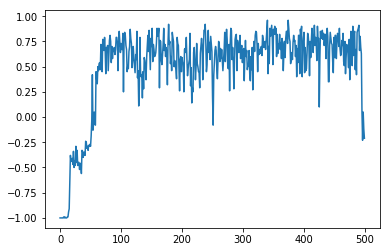

In [16]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)